In [138]:
import numpy as np
import random

from keras.models import Model, load_model
from keras.layers import Dense, Activation, Input, Reshape 
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.initializers import Zeros
import keras.backend as K

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [91]:
#this defines how your cellular automata should be updated
#run different experiments by changing the "on_numbers" list, which determines when a cell is on in the next state
#run different experiments by changing the numbers representing cell offsets in the inner loop... no need to reference adjacent cells (i.e. using offsets of 1)
def life_step(life_matrix):
    life_matrix_out = np.zeros(life_matrix.shape)
    on_numbers = [2,3]
    for i in range(0, life_matrix.shape[0]):
        for j in range(0, life_matrix.shape[1]):
            if (life_matrix[i-5,j-5]+life_matrix[i-4,j]+life_matrix[(i+3) % life_matrix.shape[0],j]+life_matrix[i,j-2]+life_matrix[i,(j+1) % life_matrix.shape[1]]) in on_numbers:
                life_matrix_out[i,j]=1 
            else:
                life_matrix_out[i,j]=0  
    return life_matrix_out

In [84]:
def plot_life(life_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(life_matrix)

    # Loop over data dimensions and create text annotations.
    for i in range(life_matrix.shape[0]):
        for j in range(life_matrix.shape[1]):
            text = ax.text(j, i, life_matrix[i, j], ha="center", va="center", color="w")

    ax.set_title("Cellular Automaton Variant")
    fig.tight_layout()
    plt.show()

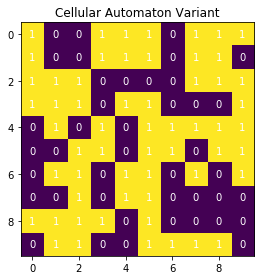

In [92]:
#run experiments by changing the proportion of on/off cells in the initial state by changing "p"
life_original = np.random.choice(a=[0,1], p=[0.5,0.5], size=(10,10))
plot_life(life_original)

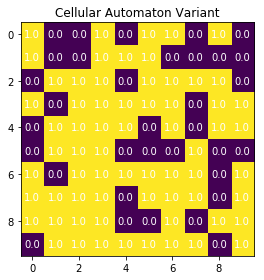

In [93]:
#before we train a neural net on anything, let's see what the next state looks like
next_step = life_step(life_original)
plot_life(next_step)

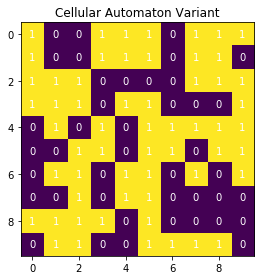

In [94]:
#what was the initial state again?
plot_life(life_original)

In [88]:
def animate_life(life_original, steps): 
    
    step_holder = np.zeros((steps, life_original.shape[0], life_original.shape[1]))
    step_holder[0] = life_original
    
    for i in range(steps-1):
        step_holder[i+1] = life_step(step_holder[i])
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()
    ax.set_title("Cellular Automaton Variant")
    im = ax.imshow(step_holder[0])
    fig.tight_layout()

    # initialization function: plot the background of each frame, I think?
    def init():
        #line.set_data([], [])
        im.set_data(step_holder[0])
        return [im]

    # animation function.  This is called sequentially, I think?
    def animate(i):
        im.set_data(step_holder[i])
        return [im]

    # call the animator.  blit=True means only re-draw the parts that have changed, I think?
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=steps, interval=500, blit=True)

    return anim

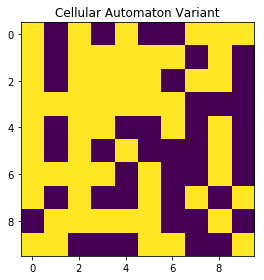

In [95]:
#ok, time to see what a cellular automaton looks like in action
#define a new initial state to run through our animation... 
#could you predict the next state if you didn't know the update rules?
#run experiments by changing the proportion of on/off cells in the initial state by changing "p"
life_original = np.random.choice(a=[0,1], p=[0.6,0.4], size=(10,10))
anim = animate_life(life_original, 100)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html

anim.save('life_animation.mp4', fps=3) #, extra_args=['-vcodec', 'libx264'])

#pick one of the two alternative video formats:
#HTML(anim.to_jshtml())
HTML(anim.to_html5_video())

In [108]:
#let's generate some training data for our neural network
#this sometimes takes a little bit if you generate a large amount of data
training_number = 50000
one_dimension = 10    
    
#generate the training data, many different inital states
#change p to run experiments
x = np.random.choice(a=[0,1], p=[0.8,0.2], size=(training_number, one_dimension, one_dimension))

#define the dimensions of the "ground truths"
y = np.zeros((x.shape[0], one_dimension*one_dimension))

#define the ground truths by using the algorithm to compute what the correct answer should be
#run experiments
#change how many steps forward the neural net will try to predict by nesting the life_step function 
#it gets harder to predict further into the future
for i in range(x.shape[0]-1):
    y[i] = life_step(x[i]).ravel() #one step forward is the correct answer for this experiment
    #y[i] = life_step(life_step(x[i])).ravel() #two steps forward is the correct answer for this experiment
    
print(x.shape)

(50000, 10, 10)


In [109]:
#Define the Neural Network Model Using Keras
#run experiments by changing the following architecture
X_input = Input(shape = (10,10))
X = Reshape((100,))(X_input)
X = Dense(100, activation = "sigmoid")(X)
X = BatchNormalization()(X)
X = Dense(100, activation = "sigmoid")(X)
X = BatchNormalization()(X)
X = Dense(100, activation = "sigmoid")(X)
X = BatchNormalization()(X)
X = Dense(100, activation = "sigmoid")(X)
X = BatchNormalization()(X)
X = Dense(100, activation = "sigmoid")(X)

model = Model(inputs = X_input, outputs = X)

#custom_metric
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def mean_true(y_true, y_pred):
    return K.mean(y_true)

#if you want to define the parameters of the Adam Optimizer
#opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.001)

#define how you want your gradient descent to be performed
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy', mean_pred, mean_true])
model.summary()
#define how much data you want to hold out for cross validation
#run experiments by changing the batch size, the number of training examples that are looked at before the model weights are updated 
#train your model longer by cycling through the data for more epochs
history = model.fit(x, y, validation_split=0.20, batch_size = 1000, epochs=30)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 10, 10)            0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_25 (Batc (None, 100)               400       
_________________________________________________________________
dense_32 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_26 (Batc (None, 100)               400       
_________________________________________________________________
dense_33 (Dense)             (None, 100)               10100     
__________

Epoch 29/30
40000/40000 [==============================] - 2s 49us/step - loss: 0.1255 - acc: 0.9924 - mean_pred: 0.2569 - mean_true: 0.2562 - val_loss: 0.1295 - val_acc: 0.9924 - val_mean_pred: 0.2627 - val_mean_true: 0.2569
Epoch 30/30
40000/40000 [==============================] - 2s 45us/step - loss: 0.1245 - acc: 0.9924 - mean_pred: 0.2568 - mean_true: 0.2562 - val_loss: 0.1285 - val_acc: 0.9924 - val_mean_pred: 0.2624 - val_mean_true: 0.2569


input:


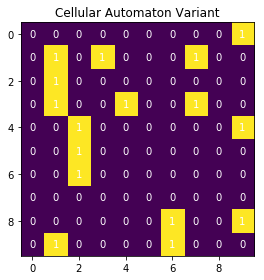

prediction:


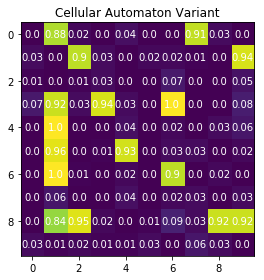

correct answer:


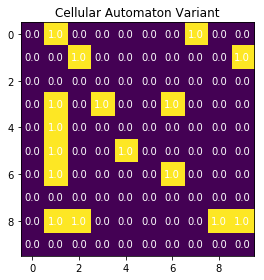

In [162]:
#our model is done training now
#lets generate some more data to test our fitted model
test_validation = 100
one_dimension = 10    
    
#generate inputs for life_step function
#p doesn't need to be what you used in training. you can see how well your model does on more or less dense cells
x_test = np.random.choice(a=[0,1], p=[0.8,0.2], size=(test_validation, one_dimension, one_dimension))

#define the shape of ground truths
y_test = np.zeros((test_validation, one_dimension*one_dimension))

#generate the correct answers for the test
#make sure you are generating correct answers that are the same number steps ahead that the model was trained on
for i in range(test_validation-1):
    y_test[i] = life_step(x_test[i]).ravel()
    
predictions = model.predict(x_test)

#look at how the first test example did
print("input:")
plot_life(x_test[0])
print("prediction:")
plot_life(np.round(predictions[0].reshape(10,10),2))
print("correct answer:")
plot_life(life_step(x_test[0]))  #also equal to y_test[0]


In [163]:
#let's see how the model did on our test data 
#it should be comparable to the cross validation accuracy we saw st the end of training

print(x_test.shape)

loss, acc, mean_pred, mean_true = model.evaluate(x_test, y_test)
print("Test set accuracy = ", acc)
print("Test set Avg Cross Entropy Error = ", loss)

(100, 10, 10)
100/100 [==============================] - 0s 156us/step
Test set accuracy =  0.9904999828338623
Test set Avg Cross Entropy Error =  0.13244097650051118


In [164]:
#let's see if we match the cross entropy error Keras calculate
#why are we off by a factor of 100?
#why do we get a div by 0 error sometimes?
Y = y_test[:]
A = predictions[:]
m = predictions.shape[0] 

cost = -(1.0/m) * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) #binary cross entropy 
#cost2 = -(1.0/m) * np.sum(Y*np.log(A)) #categorical cross entorpy

print("Our Calculated Cross Entropy: ", cost)

Our Calculated Cross Entropy:  13.244097350695206


dict_keys(['val_loss', 'val_acc', 'val_mean_pred', 'val_mean_true', 'loss', 'acc', 'mean_pred', 'mean_true'])


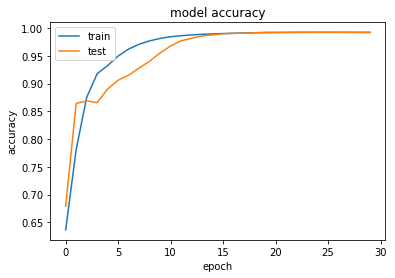

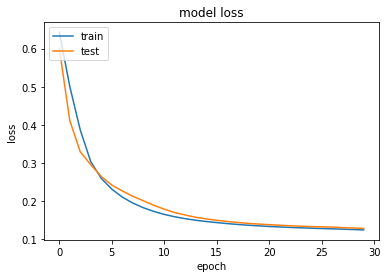

In [165]:
# list all data in history
print(history.history.keys())

#let's see some stats from our neural network training

#accuracy history
plt.plot(history.history['acc'])
#add in some test/val data that is generated and analyzed separately
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [130]:
#what do the trained model weights look like?
model.get_weights()

[array([[ 0.05099191,  0.04067201,  0.04937623, ..., -0.12767227,
          0.02142858, -0.01553503],
        [ 0.01192556,  0.2110569 , -0.12795492, ..., -0.11279719,
          0.19321233,  0.07890938],
        [ 0.07763586,  0.05254424, -0.02959044, ..., -0.06423329,
         -0.08999601,  0.04399307],
        ...,
        [-0.10064343, -0.03651047, -0.02638482, ...,  0.00348511,
         -0.09281334, -0.07898315],
        [-0.03796583,  0.03885888,  0.01193834, ...,  0.00584111,
          0.10355291, -0.1549862 ],
        [-0.07400593,  0.01218919, -0.07420047, ...,  0.08385543,
         -0.02720718,  0.061827  ]], dtype=float32),
 array([-0.23963219, -0.48354626, -0.40241453,  0.2032364 ,  0.16130081,
        -0.02282734,  0.00850645, -0.32056352, -0.14222525, -0.26128915,
         0.07741397, -0.1861758 ,  0.37391484, -0.26306793,  0.34446383,
         0.29843017, -0.18850324,  0.07962612, -0.36048898, -0.32453454,
        -0.19043475, -0.03827722, -0.07647682, -0.15313849,  0.469

In [ ]:
#change some parameters and run some new experiments
#get some intuition
#how accurate can you get your model?
#for more fun, check out "Digital Physics" the movie :)